In [61]:
import numpy as np
from skimage import graph
import matplotlib.pyplot as plt
import rasterio
import neilpy
import geopandas
import pandas as pd
from shapely.geometry import LineString
from scipy import stats

In [2]:
dataset = rasterio.open('../sample_data/sample_dem.tif')
cellsize = np.mean(dataset.res)
Z = dataset.read(1)

In [3]:
S = neilpy.slope(Z,cellsize)

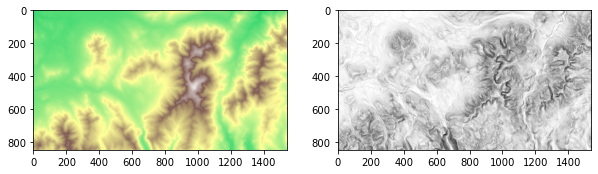

In [4]:
# Show a hysometric tint and slope raster
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.imshow(Z,cmap='terrain',vmin=-500,vmax=2000)
plt.subplot(122)
plt.imshow(S,cmap='gray_r')
plt.show()

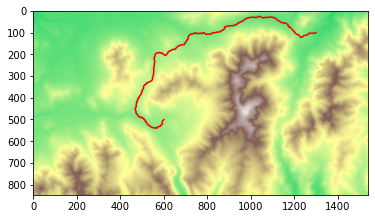

In [5]:
# Plot a route through the array, given start and ending pixels
# This will try to find a route that avoids cells with steep slope values

route, cost = graph.route_through_array(S,start=(500,600),end=(100,1300))
route = np.array(route)
plt.imshow(Z,cmap='terrain',vmin=-500,vmax=2000)
plt.plot(route[:,1],route[:,0],'r-')
plt.show()

# A Peruvian Example

<a href="https://muse.jhu.edu/book/41407" target="_blank">Rademaker et al. (2012)</a> presented some work outlining a LCP analysis between several settlements in Peru using a metabolic calculation.  This work can be implemented in Python in the following way, with one path between Quebrada Jaguay and Condorsayana as an example.

In [4]:
src = rasterio.open('../../neilpy_data/peru.tif')
Z = src.read(1)
cellsize = np.mean(src.res)
zf = neilpy.z_factor(cellsize)
Zt = rasterio.Affine(*src.get_transform())

# Reference map from Rademaker et al. (2012):
im = plt.imread('../../neilpy_data/Rademaker_LCA_energy_formula_map.png')

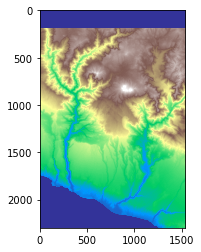

In [5]:
plt.imshow(Z,cmap='terrain',vmin=-500,vmax=6000)
plt.show()

In [6]:
# Define a GRADE raster, and set any nodata values to infinity
G = 100 * neilpy.slope(Z,cellsize,z_factor=zf,return_as='percent')
G[Z==src.nodata] = np.inf

In [7]:
# Definte model parameters
W = 50     # Weight of traveler, in kg
L = 0      # Weight of pack, in kg
tc = 1.1   # Terrain coefficient, 1 is flat and greater values introduce "friction"
V = 1.2    # Walking speed, in meters per second

# Cost, in MWatts
MW = 1.5*W + 2.0 * (W + L) * ((L/W)**2) + tc * (W+L) * (1.5 * V**2 + .35 * V * G)

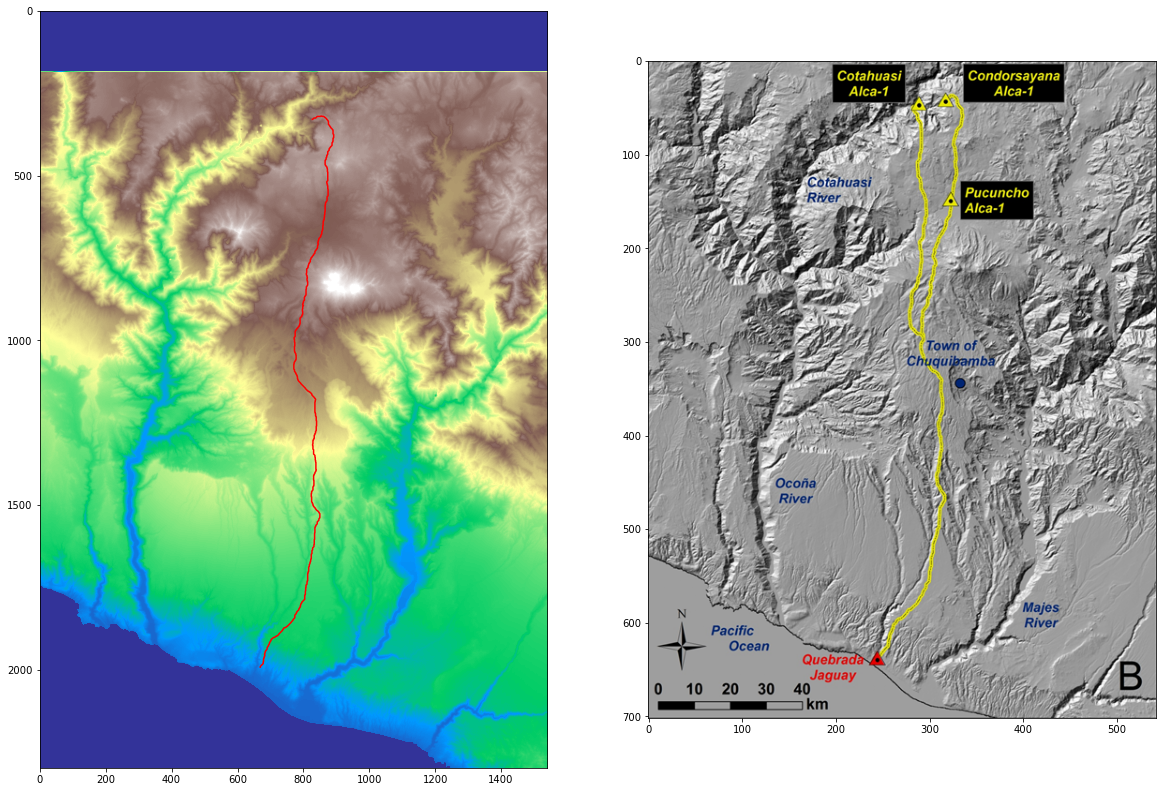

In [8]:
start = (-72.84,-16.509)
end = (-72.708,-15.123)

# Find route
# Alternative specification: ~src.transform * (-72.86,-16.509)
route, cost = graph.route_through_array(MW,src.index(*start),src.index(*end))
route = np.array(route)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(Z,cmap='terrain',vmin=-500,vmax=6000)
plt.plot(route[:,1],route[:,0],'r-')
plt.subplot(122)
plt.imshow(im)
plt.show()

# Export

In [26]:
# Recover the coordiantes like so:

lon, lat = src.transform *  np.fliplr(route).T

<AxesSubplot:>

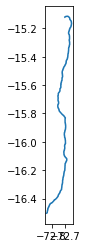

In [27]:
d = {'name': ['rademaker'], 'geometry': [LineString(zip(lon,lat))]}
df = geopandas.GeoDataFrame(d,crs=4326)
df.to_file('rademaker.shp')

# Enable beta KML writer
geopandas.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
df.to_file('rademaker.kml',driver='KML')


df.plot()

# Using an exponential PDF function as at the cost basis (Pingel 2010)

In [59]:
src = rasterio.open('../../neilpy_data/peru.tif')
Z = src.read(1)

scale_factor = 9.26 # Average slope; see Pingel (2010) page 143

S = neilpy.slope(Z,cellsize,z_factor=zf,return_as='degrees')
EXP = stats.expon.pdf(0,0,scale_factor) / stats.expon.pdf(S,0,scale_factor) 
start = (-72.84,-16.509)
end = (-72.708,-15.123)

# Find route
# Alternative specification: ~src.transform * (-72.86,-16.509)
route, cost = graph.route_through_array(EXP,src.index(*start),src.index(*end))
route = np.array(route)
lon, lat = src.transform *  np.fliplr(route).T

In [62]:
d = {'name': ['pingel'], 'geometry': [LineString(zip(lon,lat))]}
df = geopandas.GeoDataFrame(d,crs=4326)
df.to_file('pingel.shp')

# Enable beta KML writer
geopandas.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
df.to_file('pingel.kml',driver='KML')